In [1]:
import sys

sys.path.insert(0, '..')

## Setup the model area

In [2]:
from morpheus.project.types.discretization import SpatialDiscretization
from morpheus.project.types.discretization.spatial import Rotation, Grid, Crs
from morpheus.project.types.geometry import Polygon, LineString

polygon = Polygon(
  type='Polygon',
  coordinates=[[
    (13.92, 50.964),
    (13.92, 50.966),
    (13.925, 50.966),
    (13.925, 50.964),
    (13.92, 50.964)
  ]]
)

rotation = Rotation(0)

grid = Grid.cartesian_from_polygon(polygon=polygon, n_cols=100, n_rows=50, rotation=rotation)
spatial_discretization = SpatialDiscretization.from_geometry_with_grid(
  geometry=polygon,
  grid=grid,
  crs=Crs.from_str('EPSG:4326')
)

## Setup Time Discretization

In [3]:
from morpheus.project.types.discretization.time.TimeUnit import TimeUnit
from morpheus.project.types.discretization.time.Stressperiods import StartDateTime, StressPeriodCollection, \
  StressPeriod, NumberOfTimeSteps, TimeStepMultiplier, IsSteadyState
from morpheus.project.types.discretization.time import TimeDiscretization
from datetime import datetime

time_discretization = TimeDiscretization(
  start_date_time=StartDateTime.from_datetime(datetime(2020, 1, 1)),
  end_date_time=StartDateTime.from_datetime(datetime(2020, 12, 31)),
  stress_periods=StressPeriodCollection([
    StressPeriod(
      start_date_time=StartDateTime.from_datetime(datetime(2020, 1, 1)),
      number_of_time_steps=NumberOfTimeSteps(1),
      time_step_multiplier=TimeStepMultiplier(1),
      steady_state=IsSteadyState.yes()
    ),
  ]),
  time_unit=TimeUnit.days()
)

# Setup Model

In [4]:
from morpheus.project.types.Model import Model

model = Model.new()
model = model.with_updated_time_discretization(time_discretization)
model = model.with_updated_spatial_discretization(spatial_discretization=spatial_discretization)

In [5]:
import folium

m = folium.Map(tiles="cartodbpositron", crs="EPSG3857", zoom_start=12, location=[50.965, 13.922])
m.add_child(folium.GeoJson(polygon.as_geojson()))

m.fit_bounds(m.get_bounds())
m

# Setup general head boundaries

In [6]:
from morpheus.project.types.boundaries.Observation import ObservationName
from morpheus.project.types.boundaries.GeneralHeadObservation import ObservationId, GeneralHeadRawDataItem, \
  GeneralHeadObservation, Stage, Conductance
from morpheus.project.types.geometry import Point
from morpheus.project.types.boundaries.Boundary import BoundaryName, BoundaryCollection
from morpheus.project.types.layers import LayerId
from morpheus.project.types.boundaries.Boundary import GeneralHeadBoundary

layers_list = [LayerId.new()]

general_head_east = GeneralHeadBoundary.from_geometry(
  name=BoundaryName('general_head_east'),
  geometry=LineString([
    (13.92499, 50.966),
    (13.92499, 50.964),
  ]),
  grid=grid,
  affected_layers=[model.layers[0].layer_id],
  observations=[
    GeneralHeadObservation(
      observation_id=ObservationId.new(),
      observation_name=ObservationName.default(),
      geometry=Point((13.92499, 50.966)),
      data=[
        GeneralHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2019, 1, 1)),
          stage=Stage.from_float(100),
          conductance=Conductance.from_float(100),
        ),
        GeneralHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2021, 12, 31)),
          stage=Stage.from_float(100),
          conductance=Conductance.from_float(100),
        ),
      ]
    ),
  ]
)

general_head_west = GeneralHeadBoundary.from_geometry(
  name=BoundaryName('general_head_west'),
  geometry=LineString([
    (13.92004, 50.96401),
    (13.92004, 50.96599),
  ]),
  grid=grid,
  affected_layers=[model.layers[0].layer_id],
  observations=[
    GeneralHeadObservation(
      observation_id=ObservationId.new(),
      observation_name=ObservationName.default(),
      geometry=Point((13.92004, 50.96599)),
      data=[
        GeneralHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2019, 1, 1)),
          stage=Stage.from_float(100),
          conductance=Conductance.from_float(300),
        ),
        GeneralHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2021, 12, 31)),
          stage=Stage.from_float(100),
          conductance=Conductance.from_float(300),
        ),
      ]
    ),
  ]
)

boundary_collection = BoundaryCollection.new()
boundary_collection.add_boundary(general_head_west)
boundary_collection.add_boundary(general_head_east)

model = model.with_updated_boundaries(boundaries=boundary_collection)

m.add_child(folium.GeoJson(general_head_east.as_geojson()))
m.add_child(folium.GeoJson(general_head_east.affected_cells.to_geojson(grid).as_geojson()))
for observation in general_head_east.observations:
  m.add_child(folium.GeoJson(observation.as_geojson()))

m.add_child(folium.GeoJson(general_head_west.as_geojson()))
m.add_child(folium.GeoJson(general_head_west.affected_cells.to_geojson(grid).as_geojson()))
for observation in general_head_west.observations:
  m.add_child(folium.GeoJson(observation.as_geojson()))
m.fit_bounds(m.get_bounds())
m

# Setup Lake Boundary

In [7]:
from morpheus.project.types.boundaries.LakeObservation import LakeObservationValue, Precipitation, Evaporation, Withdrawal, \
  Runoff, InitialStage, BedLeakance, StageRange
from morpheus.project.types.boundaries.Boundary import LakeBoundary

lake_area = Polygon(
  type='Polygon',
  coordinates=[[
    (
      13.92181326103696,
      50.96574333352123
    ),
    (
      13.92181326103696,
      50.96440649737727
    ),
    (
      13.923994608237564,
      50.96440649737727
    ),
    (
      13.923994608237564,
      50.96574333352123
    ),
    (
      13.92181326103696,
      50.96574333352123
    )
  ]]

)

lake = LakeBoundary.from_geometry(
  name=BoundaryName('evapotranspiration'),
  geometry=lake_area,
  grid=grid,
  affected_layers=[model.layers[0].layer_id],
  data=[
    LakeObservationValue(
      date_time=StartDateTime.from_datetime(datetime(2019, 1, 1)),
      precipitation=Precipitation.from_float(0.001),
      evaporation=Evaporation.from_float(0.001),
      runoff=Runoff.from_float(0.001),
      withdrawal=Withdrawal.from_float(0.001),
    ),
    LakeObservationValue(
      date_time=StartDateTime.from_datetime(datetime(2021, 12, 31)),
      precipitation=Precipitation.from_float(0.001),
      evaporation=Evaporation.from_float(0.001),
      runoff=Runoff.from_float(0.001),
      withdrawal=Withdrawal.from_float(0.001),
    ),
  ],
  bed_leakance=BedLeakance.from_float(0.001),
  initial_stage=InitialStage.from_float(100),
  stage_range=StageRange(min=100, max=200)
)

boundary_collection.add_boundary(lake)

model = model.with_updated_boundaries(boundaries=boundary_collection)

m.add_child(folium.GeoJson(lake.as_geojson()))
m.add_child(folium.GeoJson(lake.affected_cells.to_geojson(grid).as_geojson()))
m.fit_bounds(m.get_bounds())
m

In [8]:
from morpheus.project.types.boundaries.Boundary import BoundaryType
from morpheus.project.infrastructure.calculation.engines.modflow_2005.packages.LakPackageMapper import \
  calculate_lak_boundary_stress_period_data

result = calculate_lak_boundary_stress_period_data(
  spatial_discretization=spatial_discretization,
  time_discretization=time_discretization,
  lak_boundaries=boundary_collection.get_boundaries_of_type(BoundaryType.lake),
)
result.to_dict()

{0: [[0.001, 0.001, 0.001, 0.001]]}

## Calculate

In [9]:
from morpheus.project.infrastructure.calculation.engines.base.CalculationEngineFactory import CalculationEngineFactory
from morpheus.project.types.calculation.CalculationProfile import CalculationProfile, CalculationEngineType
from morpheus.project.types.calculation.Calculation import CalculationId

calculation_id = CalculationId.new()
calculation_profile = CalculationProfile.new(CalculationEngineType.MF2005)
engine = CalculationEngineFactory.create_engine(calculation_id=calculation_id, engine_type=calculation_profile.engine_type)
check_model_log = engine.preprocess(model, calculation_profile)
check_model_log.to_list()

['type,package,k,i,j,value,desc']

In [10]:
log, result = engine.run(model=model, calculation_profile=calculation_profile)

FloPy is using the following executable to run the model: ../../../../../../../src/backend/.venv/bin/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: mf2005.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2026/02/15 13:41:54

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2026/02/15 13:41:54
 Elapsed run time:  0.032 Seconds

  Normal termination of simulation


In [11]:
result

CalculationResult(type=<CalculationResultType.SUCCESS: 'success'>, message='Calculation finished successfully', files=['mf2005.list', 'mf2005.ghb', 'mf2005.dis', 'mf2005.nam', 'mf2005.bas', 'mf2005.lpf', 'mf2005.pcg', 'mf2005.oc', 'mf2005.lak', 'mf2005.hds'], flow_head_results=AvailableResults(times=[365.0], kstpkper=[(0, 0)], number_of_layers=1, number_of_observations=0, min_value=99.9999771118164, max_value=100.0), flow_drawdown_results=None, flow_budget_results=AvailableResults(times=[365.0], kstpkper=[(0, 0)], number_of_layers=0, number_of_observations=0, min_value=None, max_value=None), transport_concentration_results=None, transport_budget_results=None, packages=['DIS', 'BAS6', 'GHB', 'LAK', 'PCG', 'LPF', 'OC'])

In [12]:
head = engine.read_flow_head(idx=0, layer=0)

In [13]:
import simplejson as json

json = json.dumps(head, ignore_nan=True)
json

'[[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 1

In [14]:
engine.read_flow_drawdown(idx=0, layer=0)

[]

In [15]:
engine.read_flow_budget(idx=0, incremental=False)

{'STORAGE_IN': 0.0,
 'CONSTANT_HEAD_IN': 0.0,
 'HEAD_DEP_BOUNDS_IN': 0.029723,
 'LAKE__SEEPAGE_IN': 0.00038386,
 'TOTAL_IN': 0.030107,
 'STORAGE_OUT': -0.0,
 'CONSTANT_HEAD_OUT': -0.0,
 'HEAD_DEP_BOUNDS_OUT': -0.00018641,
 'LAKE__SEEPAGE_OUT': -0.0014091,
 'TOTAL_OUT': -0.0015955,
 'IN-OUT': 0.028511,
 'PERCENT_DISCREPANCY': 179.87,
 'tslen': 365.0}

In [16]:
engine.read_flow_budget(idx=0, incremental=True)

{'STORAGE_IN': 0.0,
 'CONSTANT_HEAD_IN': 0.0,
 'HEAD_DEP_BOUNDS_IN': 8.1433e-05,
 'LAKE__SEEPAGE_IN': 1.0517e-06,
 'TOTAL_IN': 8.2484e-05,
 'STORAGE_OUT': -0.0,
 'CONSTANT_HEAD_OUT': -0.0,
 'HEAD_DEP_BOUNDS_OUT': -5.107e-07,
 'LAKE__SEEPAGE_OUT': -3.8606e-06,
 'TOTAL_OUT': -4.3713e-06,
 'IN-OUT': 7.8113e-05,
 'PERCENT_DISCREPANCY': 179.87,
 'tslen': 365.0}

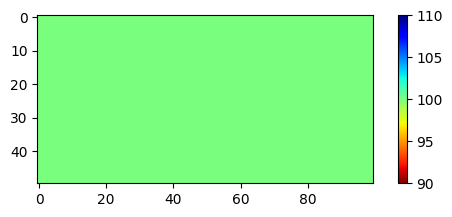

In [17]:
import matplotlib.pyplot as plt

heads = engine.read_flow_head(idx=0, layer=0)
plt.subplot(2, 1, 1)
plt.imshow(heads, cmap='jet_r')
plt.colorbar()
plt.show()